In [209]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio
import glob
import torch.nn.functional as F
import random
from tqdm import tqdm

In [23]:
data_dir = "C:/Users/DELL Inspiron/Desktop/ipnb projects/UltraSound8k"

In [25]:
audio_files = glob.glob(data_dir + "/*/*")
audio_files

['C:/Users/DELL Inspiron/Desktop/ipnb projects/UltraSound8k\\air_conditioner\\100852-0-0-0.wav',
 'C:/Users/DELL Inspiron/Desktop/ipnb projects/UltraSound8k\\air_conditioner\\100852-0-0-1.wav',
 'C:/Users/DELL Inspiron/Desktop/ipnb projects/UltraSound8k\\air_conditioner\\100852-0-0-10.wav',
 'C:/Users/DELL Inspiron/Desktop/ipnb projects/UltraSound8k\\air_conditioner\\100852-0-0-11.wav',
 'C:/Users/DELL Inspiron/Desktop/ipnb projects/UltraSound8k\\air_conditioner\\100852-0-0-12.wav',
 'C:/Users/DELL Inspiron/Desktop/ipnb projects/UltraSound8k\\air_conditioner\\100852-0-0-13.wav',
 'C:/Users/DELL Inspiron/Desktop/ipnb projects/UltraSound8k\\air_conditioner\\100852-0-0-14.wav',
 'C:/Users/DELL Inspiron/Desktop/ipnb projects/UltraSound8k\\air_conditioner\\100852-0-0-15.wav',
 'C:/Users/DELL Inspiron/Desktop/ipnb projects/UltraSound8k\\air_conditioner\\100852-0-0-16.wav',
 'C:/Users/DELL Inspiron/Desktop/ipnb projects/UltraSound8k\\air_conditioner\\100852-0-0-17.wav',
 'C:/Users/DELL Inspir

In [30]:
classes = glob.glob(data_dir+"/*")
classes = {class_.split(os.path.sep)[-1]:i for i, class_ in enumerate(classes)}

In [167]:
classes

{'air_conditioner': 0,
 'car_horn': 1,
 'children_playing': 2,
 'dog_bark': 3,
 'drilling': 4,
 'engine_idling': 5,
 'gun_shot': 6,
 'jackhammer': 7,
 'siren': 8,
 'street_music': 9}

In [71]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=16000,
                                                      n_fft=1024, hop_length=512,
                                                      n_mels=64)

In [150]:
class UrbanSoundDataset(Dataset):
    def __init__(self, data_dir, target_sample_rate, length_in_seconds, transform=None):
        super(UrbanSoundDataset, self).__init__()
        self.data_dir = data_dir
        self.target_sample_rate = target_sample_rate
        self.audio_files = glob.glob(self.data_dir+"/*/*")
        self.transform = transform
        self.length_in_seconds = length_in_seconds
        self.desired_length = self.length_in_seconds*self.target_sample_rate
        self.classes = glob.glob(data_dir + "/*")
        self.class_lookups = {class_.split(os.path.sep)[-1]:i for i, class_ in enumerate(self.classes)}
        
    def __len__(self):
        return len(self.audio_files)
    
    def __getitem__(self, idx):
        audio_dir = self.audio_files[idx]
        label = self.class_lookups[audio_dir.split(os.path.sep)[-2]]
        audio, sample_rate = torchaudio.load(audio_dir)
        if audio.shape[0] > 1:
            audio = torch.mean(audio, dim=0, keepdim=True)
        if sample_rate != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, self.target_sample_rate)
            audio = resampler(audio)
        
        if audio.shape[1] < self.desired_length:
            audio = F.pad(audio, (0, self.desired_length-audio.shape[1]))
        if audio.shape[1] > self.desired_length:
            audio = audio[..., :self.desired_length]
        
        if self.transform is not None:
            signal = self.transform(audio)
        return signal, label

In [151]:
ds = UrbanSoundDataset(data_dir, 16000, 2, transform = mel_spectrogram)

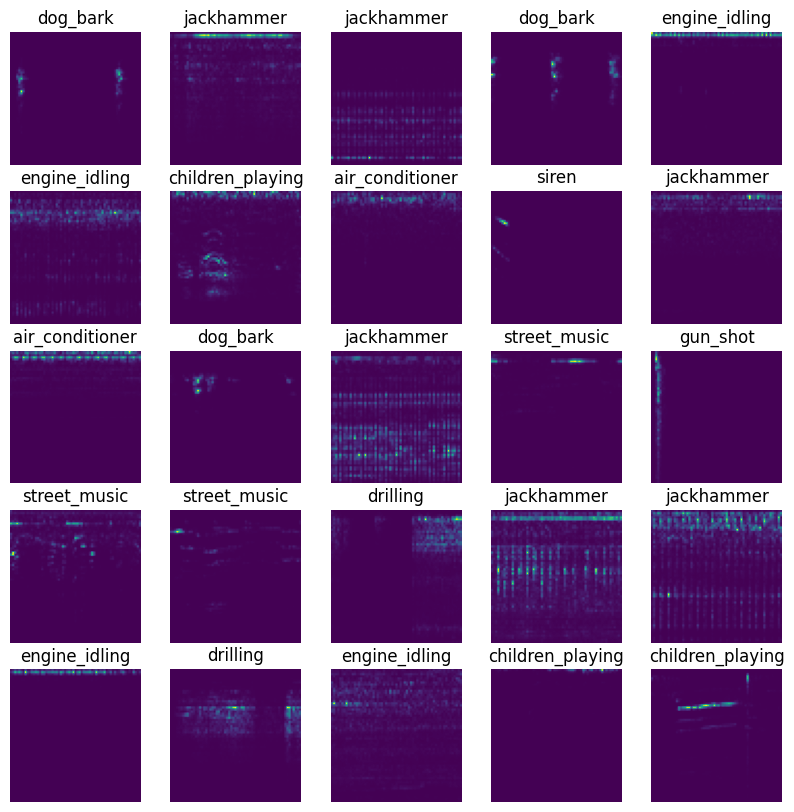

In [168]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
    signal, label = ds[random.randint(0, 8731)]
    ax[i//5, i%5].imshow(signal[0])
    ax[i//5, i%5].axis("off")
    ax[i//5, i%5].set_title(list(classes.keys())[label])

In [169]:
signal.shape

torch.Size([1, 64, 63])

In [198]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3,
                              stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3,
                              stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels = 8, kernel_size=3,
                              stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(8*8*7, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x), inplace=True)      #  N x 8 x 64 x 63
        x = self.bn1(self.pool(x))                    # N x 8 x 32 x 31
        x = F.relu(self.conv2(x), inplace=True)      # N x 16 x 32 x 31
        x = self.bn2(self.pool(x))                   # N x 16 x 16 x 15
        x = F.relu(self.conv3(x), inplace=True)      # N x 8 x 16 x 15
        x = self.bn3(self.pool(x))                   # N x 8 x 8 x 7
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

In [199]:
model = CNN()

In [200]:
model(signal.unsqueeze(0)).shape

torch.Size([1, 10])

In [203]:
train_loader = DataLoader(ds, batch_size = 16, shuffle=True)

In [208]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [210]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [212]:
for i, (x, y) in enumerate(tqdm(train_loader)):
    x = x.to(device)
    y = y.to(device)
    scores = model(x)
    loss = criterion(scores, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  4%|███▎                                                                             | 22/546 [00:11<04:22,  2.00it/s]


KeyboardInterrupt: 